In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [2]:
import os
cur_dir = "/content/drive/MyDrive/mid-term"
os.chdir(cur_dir)
!ls -la .

total 265254
-rw------- 1 root root    337117 Dec 25 21:56 baseline2.ipynb
drwx------ 2 root root      4096 Dec 26 15:36 data
-rw------- 1 root root  30110922 Dec 18 00:59 fer2013_publictest_onehot.csv
-rw------- 1 root root 240958308 Dec 18 16:00 fer2013_training_onehot.csv
-rw------- 1 root root    207891 Dec 28 04:31 model.png


In [3]:
import zipfile

with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Overview
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

# Import libraries

In [4]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

from IPython.display import SVG
from tensorflow.keras.utils import plot_model

import time
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from keras.layers import Flatten, Dropout, Dense
from keras.models import Model
from keras.regularizers import l2
from keras.applications import InceptionV3, ResNet50, VGG16

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense
from keras.layers import Flatten, Dropout, Concatenate, BatchNormalization, Input, Convolution2D, MaxPooling2D, concatenate, Activation

from keras.models import Model, Sequential, load_model

global weight_decay
weight_decay = 1e-4

""" *****************************************
MODELS
***************************************** """
torch_imagenet_mean = [0.485, 0.456, 0.406]
torch_imagenet_std = [0.229, 0.224, 0.225]

caffe_imagenet_mean = [103.939, 116.779, 123.68] # BGR
def caffe_preprocessing_input(x): # BGR
    x[..., 0] -= caffe_imagenet_mean[0]
    x[..., 1] -= caffe_imagenet_mean[1]
    x[..., 2] -= caffe_imagenet_mean[2]
    return x
# caffe_preprocessing_input

def torch_preprocessing_input(x): # BGR
    """
    torch: will scale pixels between 0 and 1
    and then will normalize each channel with respect to the
    ImageNet dataset.
    """
    x = x[...,::-1] # BGR --> RGB
    x /= 255.
    x[..., 0] -= torch_imagenet_mean[0]
    x[..., 1] -= torch_imagenet_mean[1]
    x[..., 2] -= torch_imagenet_mean[2]

    x[..., 0] /= torch_imagenet_std[0]
    x[..., 1] /= torch_imagenet_std[1]
    x[..., 2] /= torch_imagenet_std[2]
    return x
# torch_preprocessing_input

def tf_preprocess_input(x):
    """
    Image RGB
    tf: will scale pixels between -1 and 1, sample-wise.
    """
    x = x[...,::-1] # BGR --> RGB
    x = x / 127.5
    x -= 1.0
    return x
# tf_preprocess_input

def vgg16_preprocessing_input(x):
    return caffe_preprocessing_input(x)
# vgg16_preprocessing_input

def resnet50_preprocessing_input(x):
    return caffe_preprocessing_input(x)
# resnet50_preprocessing_input

def inceptionv3_preprocessing_input(x):
    return tf_preprocess_input(x)
# inceptionv3_preprocessing_input

def build_common_model(weight_path = None, model_name = None, nb_classes = 7, fc=[2048, 0], dropout = [0.1, 0.1, 0.0], input_shape = None):
    # base model
    base_model = None
    if model_name=="imagenet_inception_v3":
        input_shape = (96, 96, 3) if input_shape is None else input_shape
        base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling="avg", classes=7)
    elif model_name=="inception_v3":
        input_shape = (96, 96, 3) if input_shape is None else input_shape
        base_model = InceptionV3(include_top=False, weights=None, input_tensor=None, input_shape=input_shape, pooling="avg", classes=7)
    elif model_name=="imagenet_resnet50":
        input_shape = (48, 48, 3) if input_shape is None else input_shape
        base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling="avg", classes=7)
    elif model_name=="resnet50":
        input_shape = (48, 48, 3) if input_shape is None else input_shape
        base_model = ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=input_shape, pooling="avg", classes=7)
    elif model_name=="imagenet_vgg16":
        input_shape = (48, 48, 3) if input_shape is None else input_shape
        base_model = VGG16(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape, pooling="avg", classes=7)
    elif model_name=="vgg16":
        input_shape = (48, 48, 3) if input_shape is None else input_shape
        base_model = VGG16(include_top=False, weights=None, input_tensor=None, input_shape=input_shape, pooling="avg", classes=7)
    # if

    model = None
    if base_model is not None:
        x = base_model.output
        if dropout[0]>0: x = Dropout(dropout[0])(x)
        if fc[0]>0: x = Dense(fc[0], activation='relu')(x)
        if dropout[1] > 0: x = Dropout(dropout[1])(x)
        if fc[1]>0: x = Dense(fc[1], activation='relu')(x)
        if dropout[2] > 0: x = Dropout(dropout[2])(x)
        x = Dense(nb_classes,
                  activation='softmax',
                  name='predictions',
                  use_bias=False, trainable=True,
                  kernel_initializer='orthogonal',
                  kernel_regularizer=l2(weight_decay))(x)
        model = Model(inputs=base_model.input, outputs=x)
    # if

    if weight_path is not None: model.load_weights(weights_path, by_name = True)
    return model
# build_common_model

In [6]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [7]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

# (1) Data

### Download data at https://www.kaggle.com/datasets/dntai1983/fer2013-onehot
This source code and npy files MUST be in the same location

In [8]:
n_inputs = 2304
n_classes = 7
img_dim = 48
trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [9]:
x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

In [10]:
x_training.shape, y_training.shape

((28709, 2304), (28709, 7))

In [11]:
display(x_training[:3, :])
display(y_training[:3, :], np.argmax(y_training[:3, :], axis=1))

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.]])

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

array([0, 0, 2])

In [12]:
x_training = x_training.reshape(x_training.shape[0], 48, 48)
display(x_training.shape)
x_training = np.expand_dims(x_training, axis=3)
display(x_training.shape)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
display(x_testing.shape)
x_testing = np.expand_dims(x_testing, axis=3)
display(x_testing.shape)

(28709, 48, 48)

(28709, 48, 48, 1)

(3589, 48, 48)

(3589, 48, 48, 1)

In [13]:
y_train_labels = np.argmax(y_training, axis = 1)

In [14]:
emotion_names = np.array(["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"])

In [15]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

<BarContainer object of 7 artists>

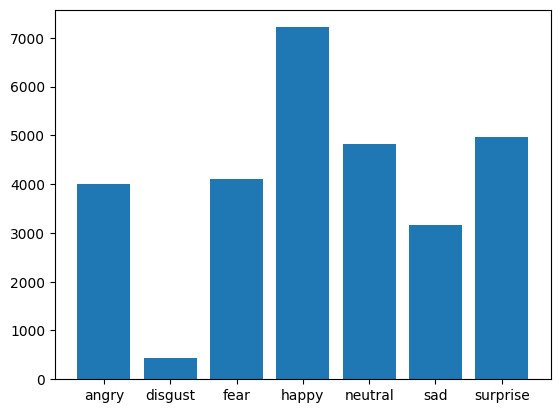

In [16]:
labels, cnts = np.unique(y_train_labels, return_counts=True)
plt.bar(emotion_names, cnts)

In [17]:
from sklearn.utils import class_weight

In [18]:
y_train_labels

array([0, 0, 2, ..., 4, 0, 4])

In [19]:
cnts / sum(cnts)

array([0.13915497, 0.01518688, 0.14270786, 0.25131492, 0.16823992,
       0.11045317, 0.17294228])

In [20]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=labels,
                                            y=y_train_labels)
weights

array([1.02660468, 9.40661861, 1.00104606, 0.56843877, 0.84912748,
       1.29337298, 0.82603942])

# (2) Declare model

In [21]:
model = build_common_model(model_name="imagenet_vgg16")
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

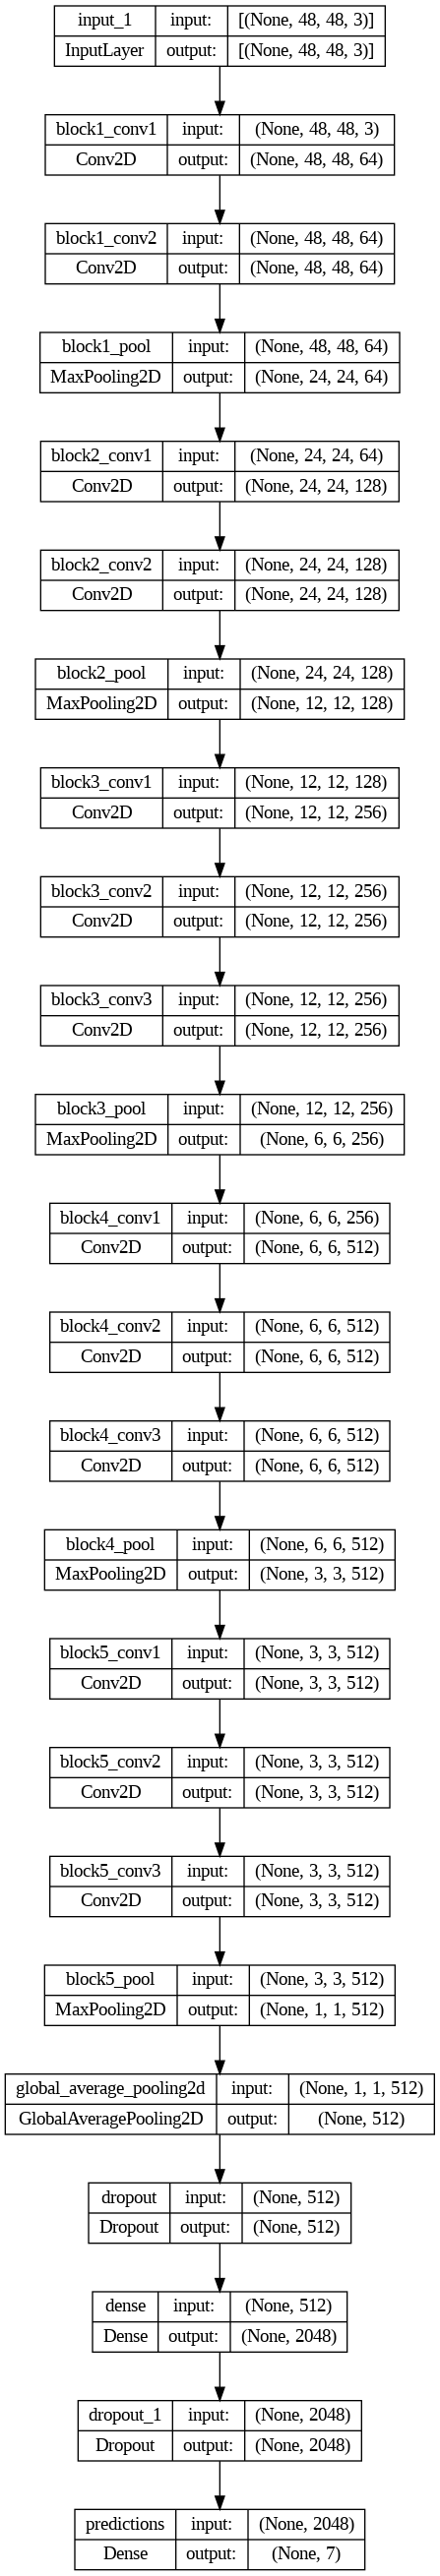

In [22]:
plot_model(model, to_file="model.png", show_shapes=True)

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [23]:
#Increase the number of channels to 3
x_training = np.repeat(x_training, 3, axis=-1)
x_testing = np.repeat(x_testing, 3, axis=-1)

### **Training Run**

---
with optimizer = SGD


In [24]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0001
model.compile(loss=loss, optimizer=SGD(learning_rate=lr), metrics=['accuracy'])

In [25]:
# train the model
batch_size = 128
epochs = 15

starting_time = time.time()
h2 = model.fit(x_training, y_training,
                    validation_data=(x_testing, y_testing),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/15
225/225 [==============================] - 35s 112ms/step - loss: 1.9876 - accuracy: 0.2432 - val_loss: 1.7730 - val_accuracy: 0.2789
Epoch 2/15
225/225 [==============================] - 22s 99ms/step - loss: 1.7496 - accuracy: 0.2989 - val_loss: 1.6603 - val_accuracy: 0.3416
Epoch 3/15
225/225 [==============================] - 23s 102ms/step - loss: 1.6698 - accuracy: 0.3424 - val_loss: 1.6219 - val_accuracy: 0.3553
Epoch 4/15
225/225 [==============================] - 23s 101ms/step - loss: 1.6167 - accuracy: 0.3661 - val_loss: 1.5794 - val_accuracy: 0.3898
Epoch 5/15
225/225 [==============================] - 24s 106ms/step - loss: 1.5794 - accuracy: 0.3842 - val_loss: 1.5377 - val_accuracy: 0.3945
Epoch 6/15
225/225 [==============================] - 24s 107ms/step - loss: 1.5432 - accuracy: 0.4023 - val_loss: 1.5060 - val_accuracy: 0.4196
Epoch 7/15
225/225 [==============================] - 24s 105ms/step - loss: 1.5189 - accuracy: 0.4144 - val_loss: 1.5177 - val_acc

### **Result of The Training Run**

In [26]:
print("Training Run:")
print("Accuracy of the Testing Set: %.2f%%" % (h2.history['val_accuracy'][14]*100))

Training Run:
Accuracy of the Testing Set: 47.73%


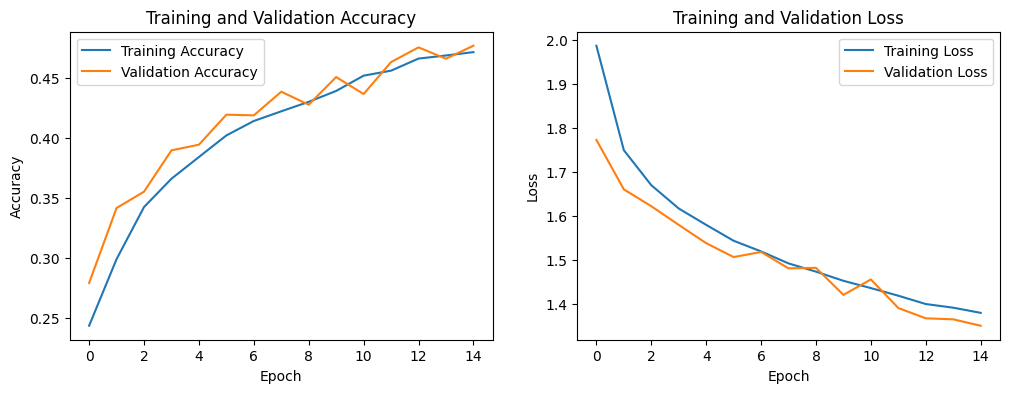

In [27]:
plot_history(h2)

In [28]:
import pandas as pd

In [29]:
pd.DataFrame(h2.history)

,loss,accuracy,val_loss,val_accuracy
0,1.987630,0.243164,1.773025,0.278908
1,1.749627,0.298861,1.660299,0.341599
2,1.669838,0.342401,1.621941,0.355252
3,1.616708,0.366087,1.579437,0.389802
4,1.579417,0.384235,1.537749,0.394539
5,1.543223,0.402278,1.506042,0.419615
6,1.518918,0.414365,1.517665,0.419058
7,1.491622,0.422446,1.480348,0.438841
8,1.472840,0.430388,1.481498,0.427974
9,1.451931,0.439479,1.419876,0.451101


### **Training time**
- Training time is about 6.4270 minutes for 15 epochs

# (4) Evaluate trained model

In [30]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

113/113 [==============================] - 2s 12ms/step - loss: 1.3496 - accuracy: 0.4773
Test loss: 1.3496240377426147
Test accuracy: 0.4772917330265045


In [31]:
def get_emotion(ohv):
    indx = np.argmax(ohv)

    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

1/1 [==============================] - 1s 772ms/step


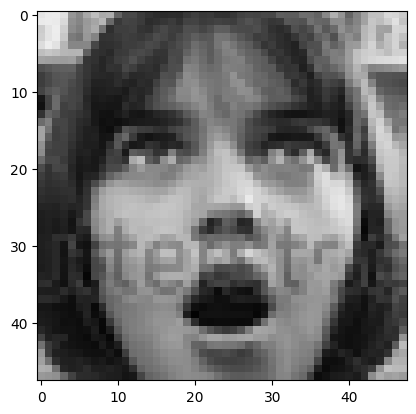

> Testing image index: 1591
> True emotion: surprise
> Predicted emotion: sad


In [32]:
img_indx = np.uint32(np.random.rand() * (testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample / 255.0

sample = np.expand_dims(sample, axis=0)
pred_cls = model.predict(sample)
plt.imshow(sample.reshape((48, 48,3)))
plt.show()

print('> Testing image index: %d\n> True emotion: %s\n> Predicted emotion: %s' % (
    img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))

In [33]:
print(sample.shape)


(1, 48, 48, 3)


In [34]:
y_test_pred = model.predict(x_testing)

113/113 [==============================] - 1s 11ms/step


In [35]:
y_test_pred_label = np.argmax(y_test_pred, axis = 1)
y_test_label = np.argmax(y_testing, axis=1)

**10 cases of incorrect predictions**

---

In [36]:
np.where(y_test_pred_label != y_test_label)

(array([   0,    1,    2, ..., 3586, 3587, 3588]),)

1/1 [==============================] - 0s 17ms/step


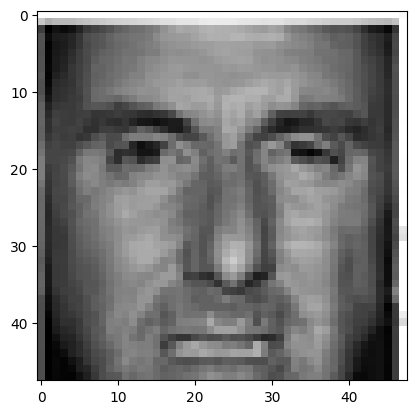

> Testing image index: 449
> True emotion: disgust
> Predicted emotion: sad
1/1 [==============================] - 0s 17ms/step


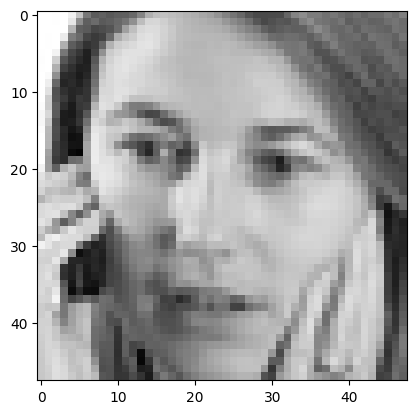

> Testing image index: 3520
> True emotion: fear
> Predicted emotion: sad
1/1 [==============================] - 0s 21ms/step


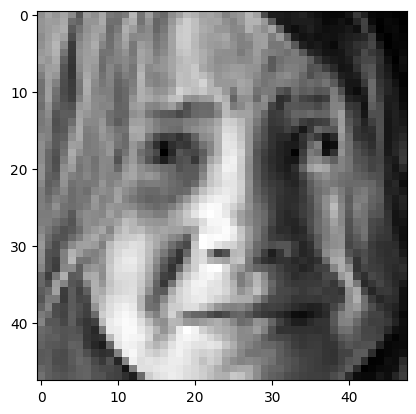

> Testing image index: 2944
> True emotion: sad
> Predicted emotion: sad
1/1 [==============================] - 0s 20ms/step


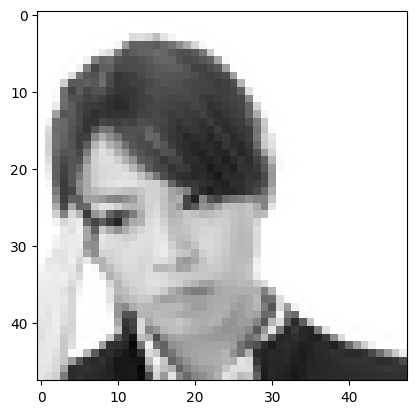

> Testing image index: 3586
> True emotion: sad
> Predicted emotion: sad
1/1 [==============================] - 0s 17ms/step


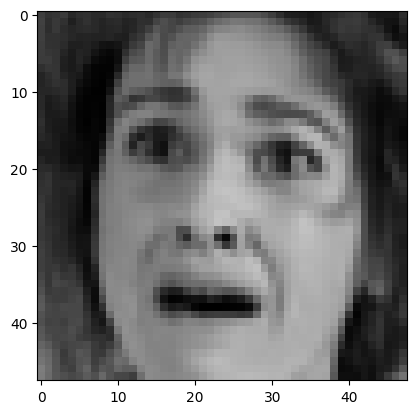

> Testing image index: 1890
> True emotion: angry
> Predicted emotion: sad
1/1 [==============================] - 0s 17ms/step


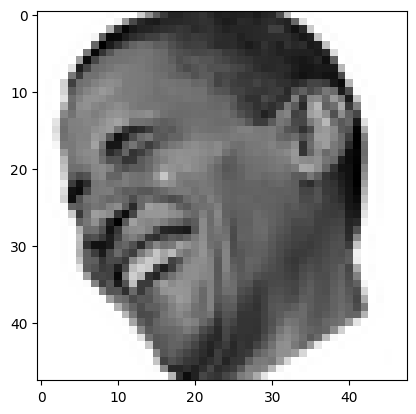

> Testing image index: 3346
> True emotion: happy
> Predicted emotion: sad
1/1 [==============================] - 0s 18ms/step


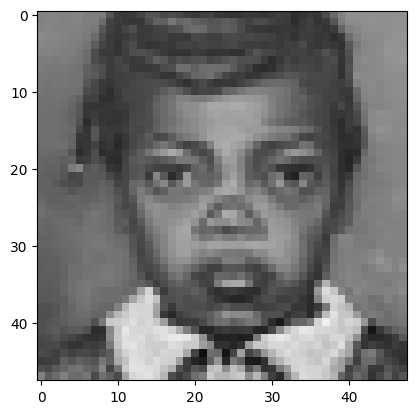

> Testing image index: 363
> True emotion: neutral
> Predicted emotion: sad
1/1 [==============================] - 0s 17ms/step


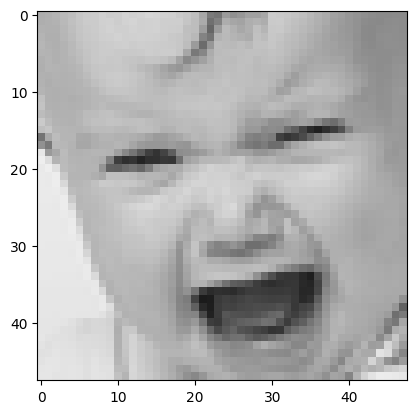

> Testing image index: 1110
> True emotion: sad
> Predicted emotion: sad
1/1 [==============================] - 0s 18ms/step


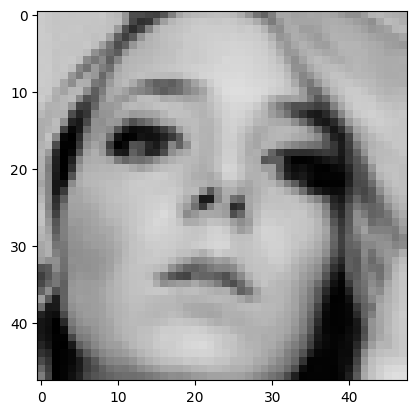

> Testing image index: 1597
> True emotion: fear
> Predicted emotion: sad
1/1 [==============================] - 0s 17ms/step


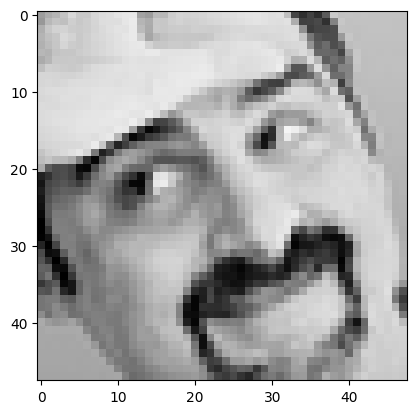

> Testing image index: 1527
> True emotion: happy
> Predicted emotion: sad


In [37]:
all_predictions = model.predict(x_testing)
mismatched_indices = np.where(np.argmax(all_predictions, axis=1) != np.argmax(y_testing, axis=1))[0]

random_mismatched_indices = np.random.choice(mismatched_indices, 10, replace=False)
for indx in random_mismatched_indices:
    sample = x_testing[indx] / 255.0
    sample = np.expand_dims(sample, axis=0)
    pred_cls = model.predict(sample)
    plt.imshow(sample.reshape((48, 48, 3)))
    plt.show()
    print('> Testing image index: %d\n> True emotion: %s\n> Predicted emotion: %s' % (
        indx, get_emotion(y_testing[indx, :]), get_emotion(pred_cls)))

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
cm = confusion_matrix(y_test_label, y_test_pred_label,  normalize='true')
cm

array([[0.25267666, 0.        , 0.0620985 , 0.18415418, 0.19914347,
        0.06852248, 0.23340471],
       [0.23214286, 0.        , 0.16071429, 0.17857143, 0.19642857,
        0.07142857, 0.16071429],
       [0.08669355, 0.        , 0.13104839, 0.12096774, 0.25      ,
        0.21572581, 0.19556452],
       [0.02681564, 0.        , 0.02346369, 0.79217877, 0.05586592,
        0.02905028, 0.0726257 ],
       [0.11332312, 0.        , 0.06431853, 0.19295559, 0.33843798,
        0.04900459, 0.24196018],
       [0.02891566, 0.        , 0.06024096, 0.06024096, 0.01686747,
        0.72771084, 0.1060241 ],
       [0.07907743, 0.        , 0.03294893, 0.18616145, 0.14991763,
        0.06095552, 0.49093904]])

In [40]:
import seaborn as sn

<Axes: >

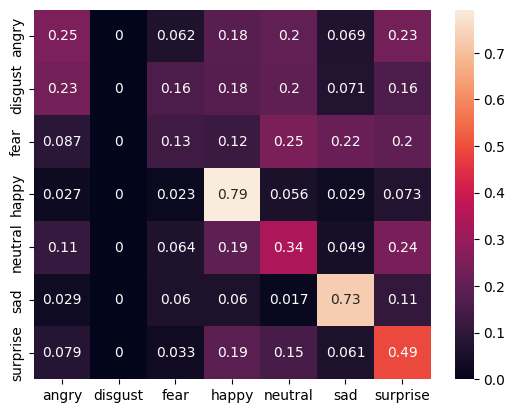

In [41]:
sn.heatmap(cm, annot=True,
           xticklabels=emotion_names, yticklabels=emotion_names)

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
        # Check if the layer is Conv2D
            if isinstance(layer, Conv2D):
                return layer.name
        raise ValueError("Could not find Conv2D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
    inputs=self.model.inputs,
    outputs=[self.model.get_layer(self.layerName).output, self.model.output]
)

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

1/1 [==============================] - 0s 29ms/step


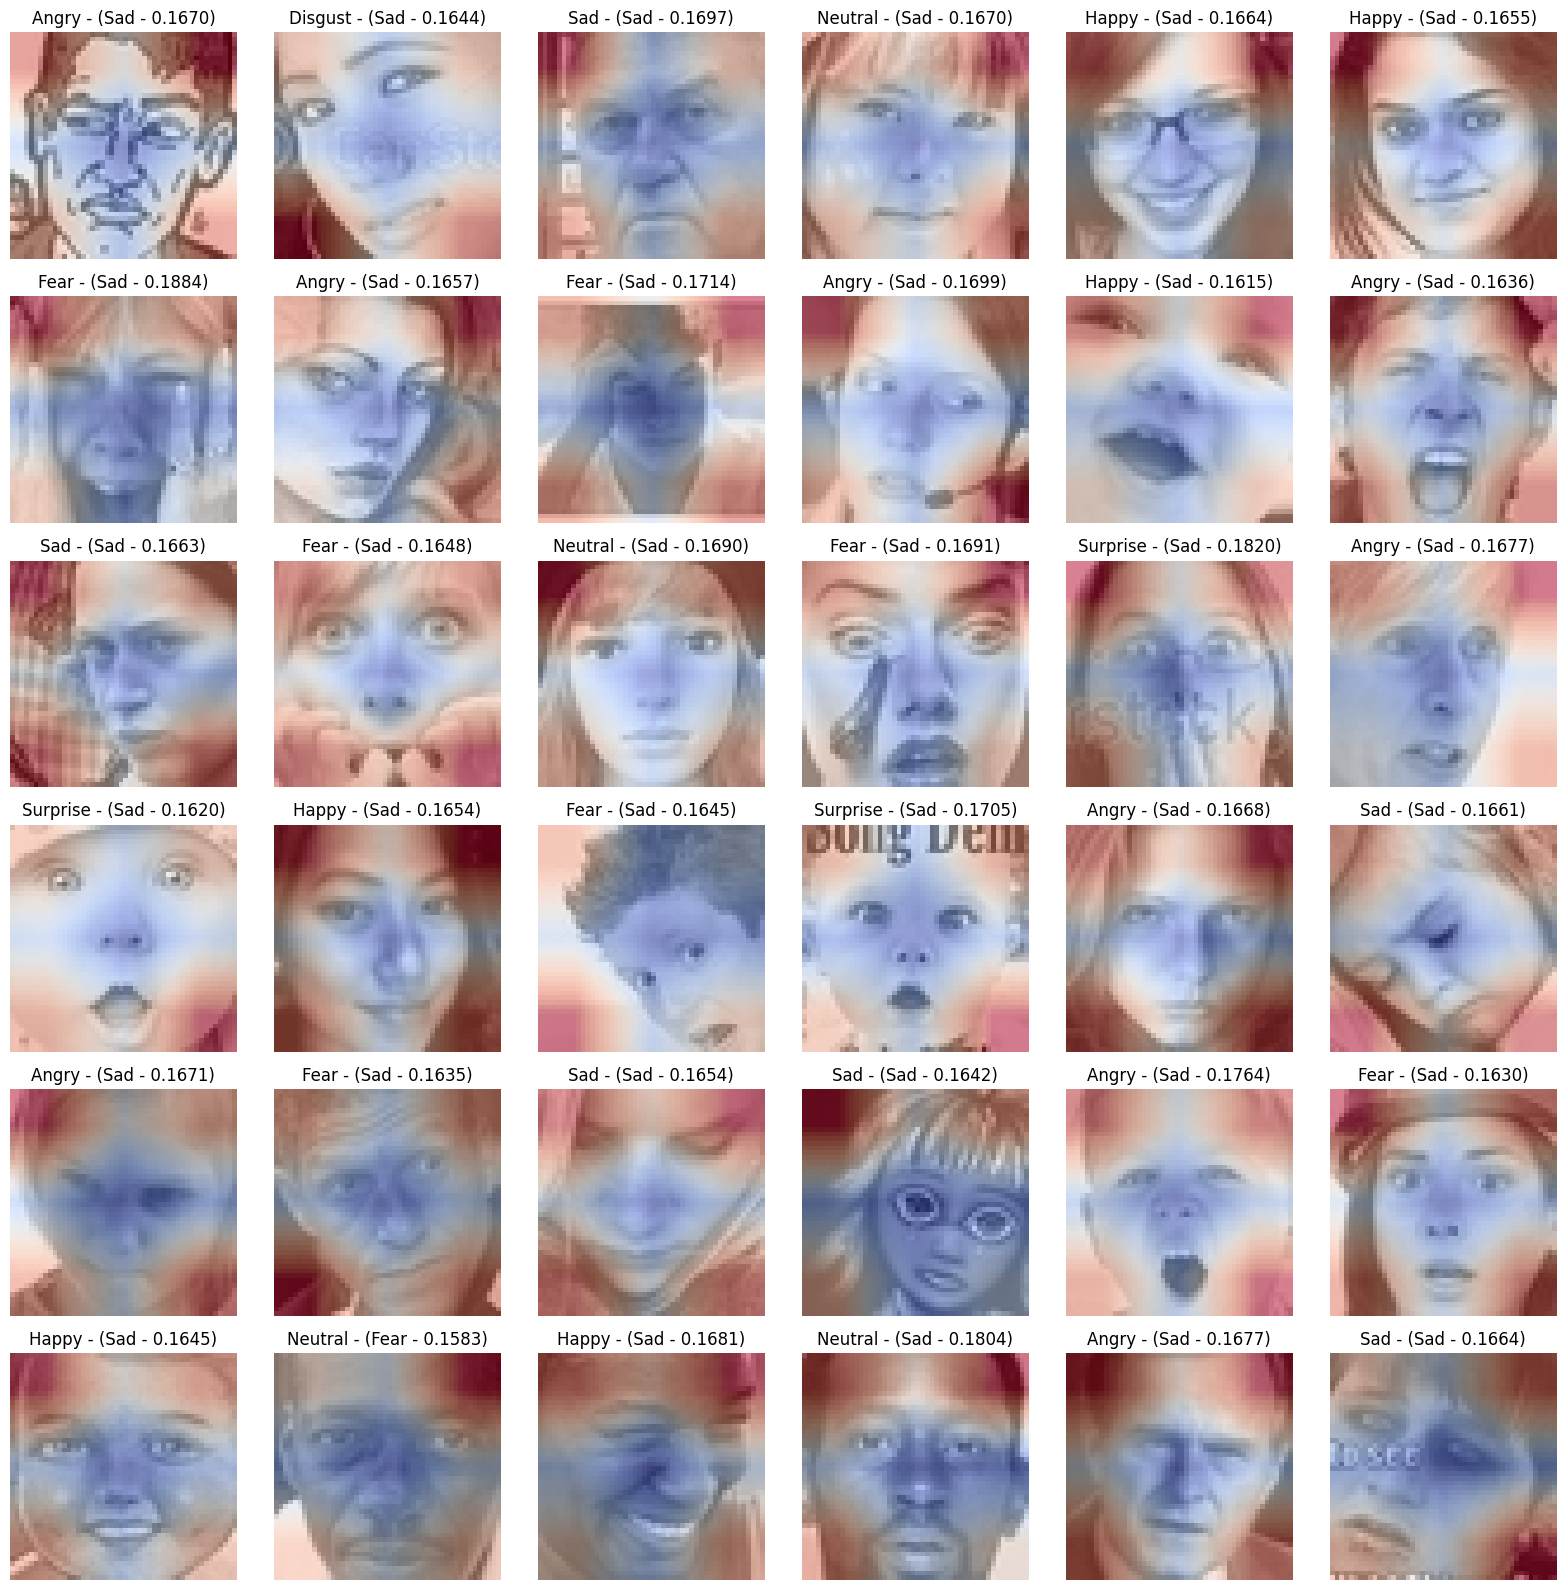

In [43]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = x_testing[i, :, :, 0]
    img_rgb = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    img_rgb = img_rgb / 255.0

    img_rgb = np.expand_dims(img_rgb, axis=0)

    p_dist = model.predict(img_rgb)
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img_rgb)

    plt.subplot(6,6,i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{emotions[y_test_label[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [44]:
!jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/baseline3.ipynb" --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/baseline3.ipynb to html
[NbConvertApp] Writing 984759 bytes to /content/drive/MyDrive/Colab Notebooks/baseline3.html
